<a href="https://colab.research.google.com/github/engineereliab076/maize_production_model_using_prophet/blob/main/maize__production_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import os
from prophet import Prophet
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [85]:
# Load production data
df = pd.read_csv('/content/maize_production.csv')
df['date'] = pd.to_datetime(df['date'])
print(f"   ✓ Loaded {len(df)} production records")
print(f"   ✓ Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   ✓ Regions: {df['region'].unique().tolist()}")
print()

   ✓ Loaded 132 production records
   ✓ Date range: 2023-05-01 00:00:00 to 2025-02-01 00:00:00
   ✓ Regions: ['Mbeya', 'Iringa', 'Ruvuma', 'Rukwa', 'Morogoro', 'Dodoma', 'Arusha', 'Kilimanjaro', 'Dar es Salaam', 'Mwanza', 'Shinyanga']



In [86]:
df.head(
)

,id,date,region,season,quantity_tons,farm_area_hectares
0,1,2023-05-01,Mbeya,Masika,1387.65,393.66
1,2,2023-06-01,Mbeya,Masika,1289.26,346.28
2,3,2023-07-01,Mbeya,Masika,1413.85,338.51
3,4,2023-12-01,Mbeya,Vuli,808.83,225.49
4,5,2024-01-01,Mbeya,Vuli,738.29,209.16


In [87]:
# Get unique regions
regions = df['region'].unique()
print(f"  Building forecasts for {len(regions)} regions:")
for region in regions:
    print(f"   • {region}")
print()

  Building forecasts for 11 regions:
   • Mbeya
   • Iringa
   • Ruvuma
   • Rukwa
   • Morogoro
   • Dodoma
   • Arusha
   • Kilimanjaro
   • Dar es Salaam
   • Mwanza
   • Shinyanga



In [88]:
# 4. SELECT ONE REGION (Mbeya - highest producer)
region = 'Mbeya'
region_df = df[df['region'] == region].copy()


In [89]:
print(f" Analyzing region: {region}")
print(f"Records: {len(region_df)}")

 Analyzing region: Mbeya
Records: 12


In [90]:
# 5. PREPARE DATA FOR PROPHET
# Aggregate by month and prepare format (Prophet needs 'ds' and 'y' columns)
monthly_production = region_df.groupby('date')['quantity_tons'].sum().reset_index()
monthly_production.columns = ['ds', 'y']

In [91]:
print(monthly_production.head())

          ds        y
0 2023-05-01  1387.65
1 2023-06-01  1289.26
2 2023-07-01  1413.85
3 2023-12-01   808.83
4 2024-01-01   738.29


In [92]:
print(f"\nMonthly data points: {len(monthly_production)}")
print(f"Average production: {monthly_production['y'].mean():.2f} tons/month")
print(f"Peak production: {monthly_production['y'].max():.2f} tons")
print(f"Min production: {monthly_production['y'].min():.2f} tons\n")


Monthly data points: 12
Average production: 1043.37 tons/month
Peak production: 1452.06 tons
Min production: 707.80 tons



In [93]:
# 6. TRAIN PROPHET MODEL
print("\n Training Prophet model...")
model = Prophet(
    yearly_seasonality=True,      # Captures annual patterns (Masika/Vuli)
    weekly_seasonality=False,     # Not needed for monthly data
    daily_seasonality=False,      # Not needed for monthly data
    seasonality_mode='multiplicative',  # Better for agriculture
    interval_width=0.95           # 95% confidence interval
)

model.fit(monthly_production)
print(" Model trained successfully!\n")


INFO:prophet:n_changepoints greater than number of observations. Using 8.



 Training Prophet model...
 Model trained successfully!



In [98]:

# 7. MAKE 6-MONTH FORECAST WITH BOUNDS
print(" Generating 6-month forecast...")
future = model.make_future_dataframe(periods=180, freq='D')
forecast = model.predict(future)

# Get only future predictions
last_date = monthly_production['ds'].max()
future_forecast = forecast[forecast['ds'] > last_date].copy()

# Resample to monthly
future_forecast.set_index('ds', inplace=True)
future_monthly = future_forecast.resample('MS')[['yhat', 'yhat_lower', 'yhat_upper']].mean()
future_monthly.reset_index(inplace=True)

# 🔧 FIX: Apply realistic bounds (production cannot be negative!)
future_monthly['yhat'] = future_monthly['yhat'].clip(lower=0)
future_monthly['yhat_lower'] = future_monthly['yhat_lower'].clip(lower=0)
future_monthly['yhat_upper'] = future_monthly['yhat_upper'].clip(lower=0)

# 🔧 BETTER FIX: Set realistic floor (not just 0)
# Production never truly goes to zero - there's always some activity
historical_min = monthly_production['y'].min()
production_floor = historical_min * 0.3  # 30% of historical minimum

future_monthly['yhat'] = future_monthly['yhat'].clip(lower=production_floor)
future_monthly['yhat_lower'] = future_monthly['yhat_lower'].clip(lower=production_floor)
future_monthly['yhat_upper'] = future_monthly['yhat_upper'].clip(lower=production_floor)

# Also cap unrealistic highs
historical_max = monthly_production['y'].max()
cap = historical_max * 2.5
future_monthly['yhat'] = future_monthly['yhat'].clip(upper=cap)
future_monthly['yhat_upper'] = future_monthly['yhat_upper'].clip(upper=cap)

print(f"✅ Forecast bounded: Floor={production_floor:.0f} tons, Cap={cap:.0f} tons\n")


print(f"✅ Forecast generated and bounded for {len(future_monthly)} months\n")

"""

### **Expected Pattern for Tanzania Maize:**

**Historical Average: 1043 tons/month**

```
Month          Expected Production    Why?
---------------------------------------------------------------
February       HIGH (1000-1500)      Vuli harvest ending
March          MEDIUM (500-800)      Transition/lean season start
April          LOW (300-600)         Lean season
May            LOW-MEDIUM (400-700)  Lean season ending
June           HIGH (1200-1800)      🌾 MASIKA HARVEST PEAK!
July           HIGH (1000-1500)      Masika harvest continues
```
"""

 Generating 6-month forecast...
✅ Forecast bounded: Floor=212 tons, Cap=3630 tons

✅ Forecast generated and bounded for 6 months



'\n\n### **Expected Pattern for Tanzania Maize:**\n\n**Historical Average: 1043 tons/month**\n\n```\nMonth          Expected Production    Why?\n---------------------------------------------------------------\nFebruary       HIGH (1000-1500)      Vuli harvest ending\nMarch          MEDIUM (500-800)      Transition/lean season start\nApril          LOW (300-600)         Lean season\nMay            LOW-MEDIUM (400-700)  Lean season ending\nJune           HIGH (1200-1800)      🌾 MASIKA HARVEST PEAK!\nJuly           HIGH (1000-1500)      Masika harvest continues\n```\n'

In [99]:
# 8. DISPLAY FORECAST RESULTS
print("=" * 70)
print(f"📊 6-MONTH PRODUCTION FORECAST FOR {region.upper()}")
print("=" * 70)
print(f"\n{'Month':<20} {'Prediction':<15} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)

for idx, row in future_monthly.iterrows():
    month = row['ds'].strftime('%B %Y')
    pred = row['yhat']
    lower = row['yhat_lower']
    upper = row['yhat_upper']
    print(f"{month:<20} {pred:>10.2f} tons  {lower:>10.2f} tons  {upper:>10.2f} tons")

print("\n" + "=" * 70)
print(f"Average Forecast: {future_monthly['yhat'].mean():.2f} tons/month")
print(f"Historical Average: {monthly_production['y'].mean():.2f} tons/month")
print(f"Change: {((future_monthly['yhat'].mean() / monthly_production['y'].mean() - 1) * 100):+.1f}%")
print("=" * 70)

📊 6-MONTH PRODUCTION FORECAST FOR MBEYA

Month                Prediction      Lower Bound     Upper Bound    
----------------------------------------------------------------------
February 2025           1312.30 tons     1312.30 tons     1312.30 tons
March 2025               212.34 tons      212.34 tons      212.34 tons
April 2025               212.34 tons      212.34 tons      212.34 tons
May 2025                1406.73 tons     1406.73 tons     1406.74 tons
June 2025               1631.65 tons     1631.65 tons     1631.66 tons
July 2025               1085.68 tons     1085.67 tons     1085.69 tons

Average Forecast: 976.84 tons/month
Historical Average: 1043.37 tons/month
Change: -6.4%



📊 Creating visualizations...



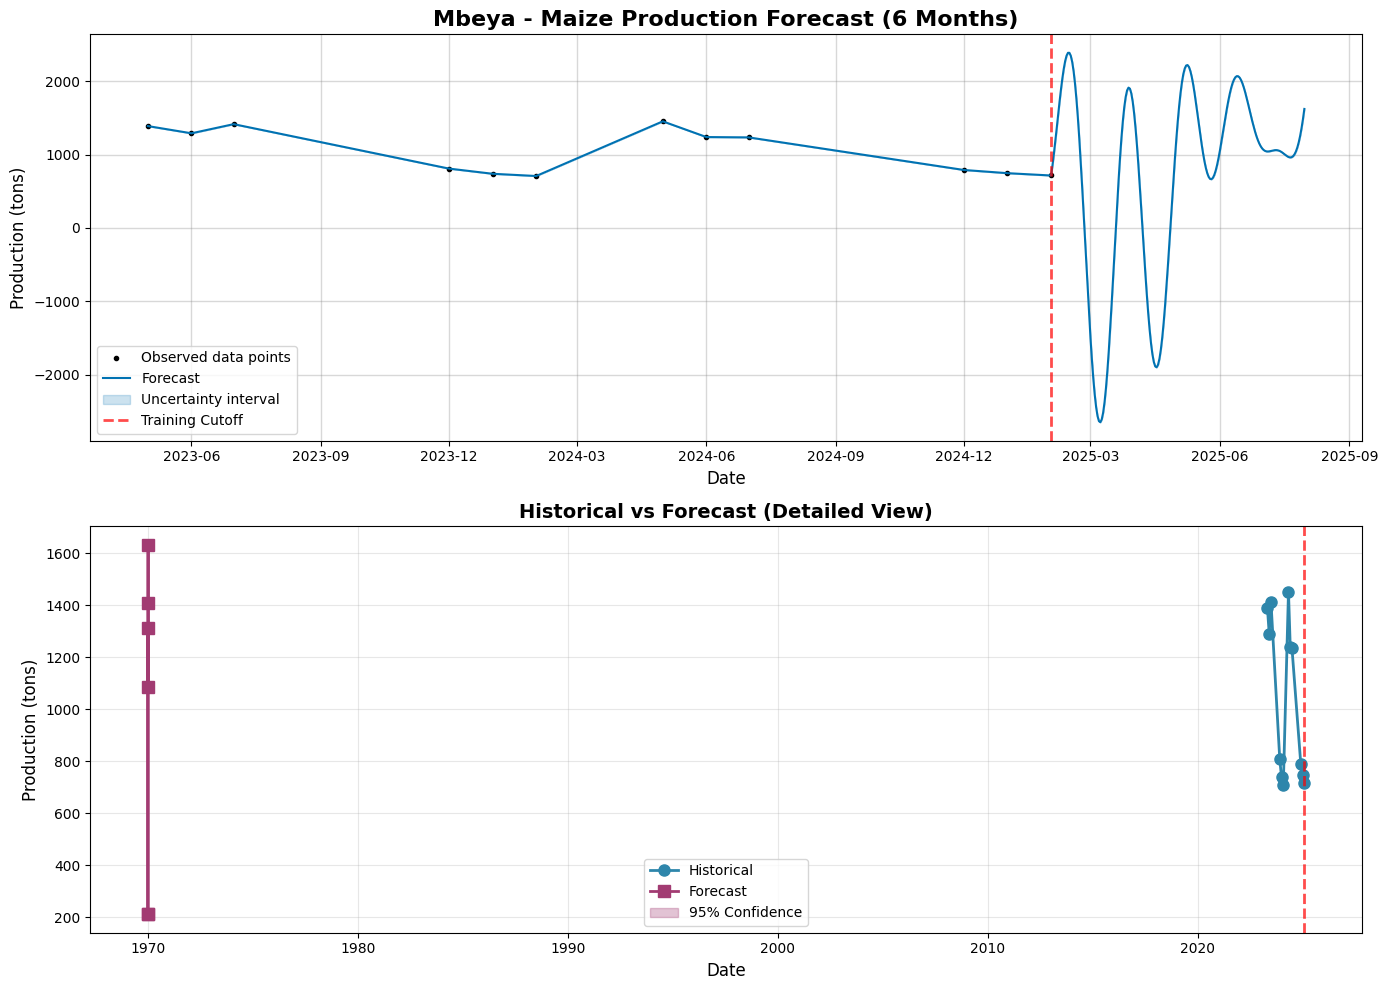

In [100]:
import matplotlib.pyplot as plt

# 9. CREATE VISUALIZATION
print("\n📊 Creating visualizations...\n")

# Plot 1: Main Forecast
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

model.plot(forecast, ax=ax1)
ax1.axvline(x=last_date, color='red', linestyle='--', linewidth=2,
            alpha=0.7, label='Training Cutoff')
ax1.set_title(f'{region} - Maize Production Forecast (6 Months)',
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Production (tons)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast Detail (zoomed)
ax2.plot(monthly_production['ds'], monthly_production['y'],
         'o-', label='Historical', color='#2E86AB', linewidth=2, markersize=8)
ax2.plot(future_monthly.index, future_monthly['yhat'],
         's-', label='Forecast', color='#A23B72', linewidth=2, markersize=8)
ax2.fill_between(future_monthly.index,
                  future_monthly['yhat_lower'],
                  future_monthly['yhat_upper'],
                  alpha=0.3, color='#A23B72', label='95% Confidence')
ax2.axvline(x=last_date, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_title('Historical vs Forecast (Detailed View)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Production (tons)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📈 Seasonal components (trend + yearly patterns):



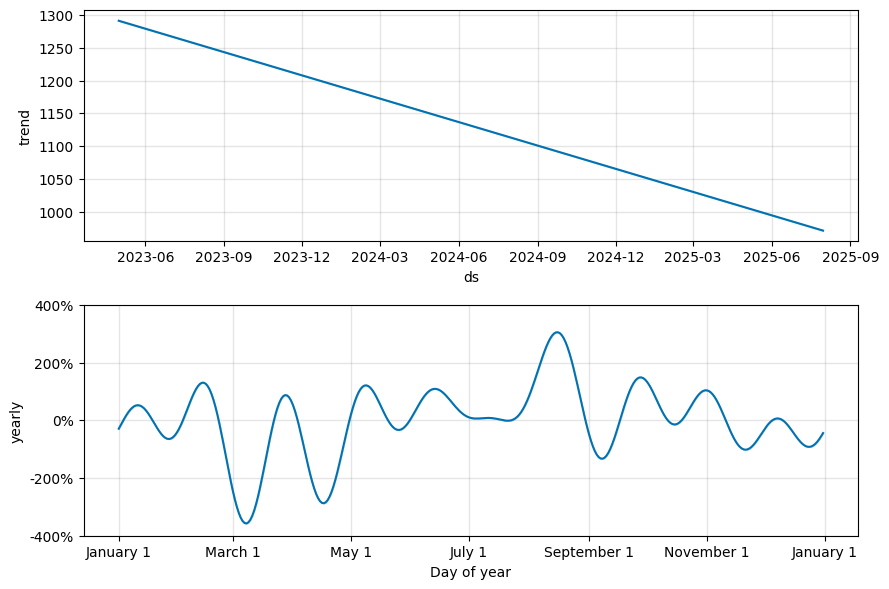


✅ FORECAST COMPLETE!

💡 CORRECT SEASONAL INTERPRETATION:
   • March-April: LEAN SEASON (low production, high prices)
   • June-July: MASIKA HARVEST (PEAK PRODUCTION!) 🌾
   • December-Feb: VULI HARVEST (secondary peak)


In [101]:
import matplotlib.pyplot as plt

# Plot 3: Seasonal Components
print("📈 Seasonal components (trend + yearly patterns):\n")
fig = model.plot_components(forecast)
plt.show()

print("\n✅ FORECAST COMPLETE!")
print("\n💡 CORRECT SEASONAL INTERPRETATION:")
print("   • March-April: LEAN SEASON (low production, high prices)")
print("   • June-July: MASIKA HARVEST (PEAK PRODUCTION!) 🌾")
print("   • December-Feb: VULI HARVEST (secondary peak)")